In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [2]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 1.2MB/s 
     |████████████████████████████████| 3.1MB 30.3MB/s 
     |████████████████████████████████| 501kB 52.0MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv \
    -O /tmp/daily-total-female-births.csv

--2019-10-01 15:04:11--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6220 (6.1K) [text/plain]
Saving to: ‘/tmp/daily-total-female-births.csv’

/tmp/daily-total-fe 100%[===================>]   6.07K  --.-KB/s    in 0s      

2019-10-01 15:04:11 (63.5 MB/s) - ‘/tmp/daily-total-female-births.csv’ saved [6220/6220]



In [0]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(series, time, start=0, end=None, format="-"):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)



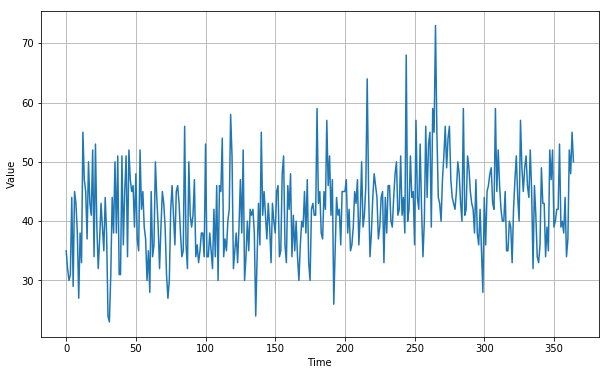

In [11]:
import csv

time_steps = []
birth = []

with open('/tmp/daily-total-female-births.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for i, line in enumerate(reader):
    birth.append(float(line[1]))
    time_steps.append(i)

time = np.array(time_steps)
series = np.array(birth)
plt.figure(figsize=(10,6))
plot_series(series, time)

In [0]:
split_time=300
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size=30
batch_size=10
shuffle_buffer_size=100

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x: x.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer_size)
  ds = ds.map(lambda x: (x[:-1], x[1:]))
  ds = ds.batch(batch_size).prefetch(1)

  return ds

In [0]:
def model_forcast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda x: x.batch(window_size))
  ds = ds.batch(batch_size).prefetch(1)
  forcast = model.predict(ds)
  
  return forcast 

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(52)
np.random.seed(51)

window_size = 30
batch_size=128

train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_dataset)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [22]:
print(x_train.shape)

(300,)


In [25]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(60, strides=1, kernel_size=5, padding='causal', activation='relu', input_shape=[None,1]),
                                    tf.keras.layers.LSTM(30, return_sequences=True),
                                    tf.keras.layers.LSTM(30, return_sequences=True),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(15, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x:x*75)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 30)          10920     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 30)          7320      
_________________________________________________________________
dense_5 (Dense)              (None, None, 30)          930       
_________________________________________________________________
dense_6 (Dense)              (None, None, 15)          465       
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           16        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)          

In [27]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epochs: 1e-8 * 10**(epochs/20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
history=model.fit(train_dataset, epochs=100, callbacks=[lr_scheduler])

Epoch 1/100
9/9 [==============================] - 3s 362ms/step - loss: 38.9355 - mae: 39.3453
Epoch 2/100
9/9 [==============================] - 0s 37ms/step - loss: 38.7708 - mae: 39.1922
Epoch 3/100
9/9 [==============================] - 0s 39ms/step - loss: 38.5213 - mae: 38.9444
Epoch 4/100
9/9 [==============================] - 0s 36ms/step - loss: 38.1990 - mae: 38.6236
Epoch 5/100
9/9 [==============================] - 0s 36ms/step - loss: 37.8026 - mae: 38.2287
Epoch 6/100
9/9 [==============================] - 0s 35ms/step - loss: 37.3216 - mae: 37.7499
Epoch 7/100
9/9 [==============================] - 0s 35ms/step - loss: 36.7413 - mae: 37.1729
Epoch 8/100
9/9 [==============================] - 0s 35ms/step - loss: 36.0563 - mae: 36.4916
Epoch 9/100
9/9 [==============================] - 0s 36ms/step - loss: 35.2888 - mae: 35.7271
Epoch 10/100
9/9 [==============================] - 0s 35ms/step - loss: 34.4793 - mae: 34.9197
Epoch 11/100
9/9 [==============================

[1e-08, 0.0001, 0, 60]

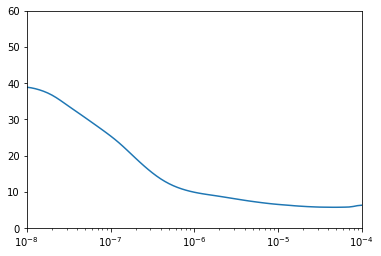

In [30]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8,1e-4,0,60])

In [86]:
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(60, strides=1, kernel_size=3, padding='causal', activation='relu', input_shape=[None,1]),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.Dense(60, activation='relu'),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x:x*100)])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
history=model.fit(train_dataset, epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 1s/step - loss: 24.3310 - mae: 32.3369
Epoch 2/100
3/3 [==============================] - 0s 122ms/step - loss: 30.4869 - mae: 36.0103
Epoch 3/100
3/3 [==============================] - 0s 124ms/step - loss: 6.6493 - mae: 7.0999
Epoch 4/100
3/3 [==============================] - 0s 117ms/step - loss: 6.1164 - mae: 6.7428
Epoch 5/100
3/3 [==============================] - 0s 118ms/step - loss: 5.9062 - mae: 6.4213
Epoch 6/100
3/3 [==============================] - 0s 116ms/step - loss: 5.5947 - mae: 6.2080
Epoch 7/100
3/3 [==============================] - 0s 113ms/step - loss: 5.5968 - mae: 6.0633
Epoch 8/100
3/3 [==============================] - 0s 122ms/step - loss: 5.2858 - mae: 5.8032
Epoch 9/100
3/3 [==============================] - 0s 124ms/step - loss: 5.5429 - mae: 6.1062
Epoch 10/100
3/3 [==============================] - 0s 120ms/step - loss: 5.4033 - mae: 5.9217
Epoch 11/100
3/3 [==============================] - 0s 119

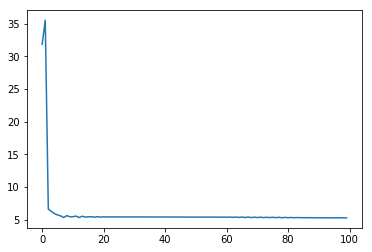

In [87]:
plt.plot(range(100),history.history['loss'])

In [0]:
rnn_forcast = model_forcast(model, series[...,np.newaxis], window_size)
rnn_forcast = rnn_forcast[split_time-window_size:-1,-1,0]

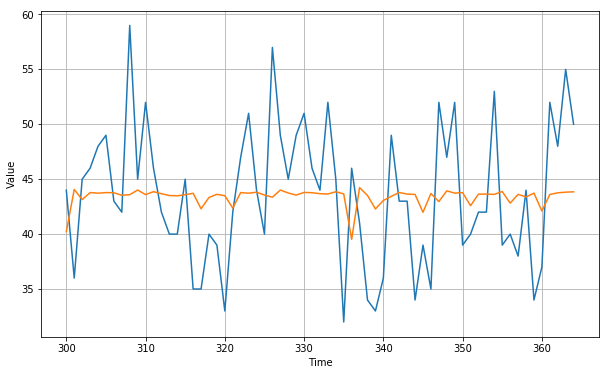

In [89]:
plt.figure(figsize=(10,6))
plot_series(x_valid, time_valid)
plot_series(rnn_forcast, time_valid)

In [90]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forcast).numpy()

5.1240153